# Group Project - OOP2

<b>Pin-Hung Chen, Yu-Chun Chen, Jianqi Zhu</b>

## 1 Introduction

### 1.1 API

API (Application programming interface) is a method that users can interact with applications by coding. Specifically, for a financial data API, investors can access financial data through various commands or API calls in their IDE.

In this project, we mainly learn how to use the IEX API. The reason why we choose it is that IEX has typical feasures like API throttling and authentication as in our project instruction. It is not only a powerful tool to access panel data in financial market, but also a good example of API.

The API requests vary for different APIs. An IEX API requst contains four fundamental components:
<ol>
<li> Base Url </li>
<li> Version </li>
<li> Endpoint path </li>
<li> Query string </li>
</ol>

The return constains a json file.

The IEX API is paid. It will measure the amount of data which users request each time and charge them. To avoid charging clients unnecessarily, IEX provides a free testing sandbox, which helps users figure out whether their requests return the data they want as well as evaluate how much the users pay for them. However, the data that sandbox returns are not real. They are simulated or being added some white noise from the real data. For the sake of cost, we are using the testing sandbox in the project and in the end we will use sandbox as an example to discuss the features of an API such as API throttling and authentication. 

### 1.2 Algorithm trading strategy

Our team is going to develop an algorithm trading strategy in a pure techinical way. We only use time series of price and volume to generate trading signals. The analysis of time series involves cross-sectional regression and simple exponential smoothing. The strategy turns out to generate a satisfactory return. Next, we will discuss how we manage the data and implement the strategy with IEX API in detail.

## 2 Methodologies and codes

### 2.1 Packages

Numpy, Pandas, Math, Scipy and Statsmodels are basic packages to conduct data analysis. Datetime helps us to slice and match time series data. Matplotlib is a tool of visualization. These are all commonly used packages in Python. Besides, Requests is ususally used in crawler programs. Here we use it to request data from IEX API in the form of json file.


Once we register an account on IEX Cloud, we will have access to our own sandbox API token. By importing the token in our Python script, we can then have API calls. 
```Python
from secrets import IEX_CLOUD_API_TOKEN
```

`sp_500_stocks.csv` is a csv file containing the tickers of SP&500 stocks. The tickers are the keys to access data from sandbox.

In [1]:
import numpy as np
import pandas as pd
import requests #request data from website
import xlsxwriter #The libary output excel
import math
from scipy import stats #The SciPy stats module
from statistics import mean

import datetime as dt
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt

stocks = pd.read_csv('sp_500_stocks.csv')
from secrets import IEX_CLOUD_API_TOKEN

### 2.2 Get ticker strings to have a batch request

Generally, we can use a for loop of API calls to request data of more than one stocks. However, its efficiency is relatively low and it requires our extra efforts to manage the data. IEX provides batch function call where we can get time series of many stocks at the same time. With the help of generator, we write a **chunk** function to split the 500 stocks into batches of 100 stocks, because the API will decline the request if more than 100 stocks in a batch.

The function **get_symbol_strings** convert one batch of stocks into a string of comma seperated tickers. 

In [2]:
def chunks(lst, n):
    """Yield successive n-sized chunks from lst."""
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

def get_symbol_strings(tickers_list):
    symbol_groups = list(chunks(tickers_list, 100))
    symbol_strings = []
    for i in range(0, len(symbol_groups)):
        symbol_strings.append(','.join(symbol_groups[i]))
    #     print(symbol_strings[i])
    return symbol_strings

As we mentioned in section 1.1, the first three components in an API request is defined as following. We would want to merge the three components with the string of comma seperated tickers and yield a complete request string.

In [3]:
base_url = 'https://sandbox.iexapis.com/'
version = 'stable/'
end_point = 'stock/market/batch'

### 2.3 Construct a factor data frame for each stock

The purpose of this step is to construct a dictionary of data frames. The data frame for each single stock contains the techinical factors that we want to use to generate trading signals. We first take batch API calls to get json objects and use **.json()** to parse them. From the resulting data frame, we only need the daily open, close, highest and lowest prices and trading volume. Using **extract_factor** function defined in the next cell, we calculate the columns of technical factors we select for this project and output only these columns as a data frame to our factor dictionary **factor_dict**.

The technical factors we select are the following:
- **close**: the close price today
- **high_vs_low**: percentage daily price variation $$\frac{\text{high}-\text{low}}{\text{open}}$$
- **three_vs_thirteen_days**: 3-day moving average divided by 30-day moving average (typo:the column name should be actually three_vs_thirty_days)
- **relative_volume**: a normalized measure of daily trading volume $$\frac{\text{daily volume} - \text{30-day average volume}}{\text{standard deviation of 30-day average volume}}$$ 
- **next_day_log_return**: The observed log return next day. Note that this is the dependent variable in our later cross sectional regression. We want to use the above three factors to predict the log return next day.

Here, we display a sample data frame of AAPL, which is a value in the factor dictionary **factor_dict**.

In [4]:
def extract_factor(df):
    df['high_vs_low'] = (df.high - df.low)/df.open
    df['three_vs_thirteen_days'] = np.nan
    df['relative_volume'] = np.nan
    df['next_day_log_return'] = np.log(df.close.pct_change() + 1).shift(-1)
    for ind in df.index[29:]:
        df['three_vs_thirteen_days'].iloc[ind] = mean(df.close.iloc[ind-2:ind]) / mean(df.close.iloc[ind-29:ind])

        mean_volume = mean(df.volume.iloc[ind-29:ind])
        std_volume = np.std(df.volume.iloc[ind-29:ind])
        df['relative_volume'].iloc[ind] = (df.volume.iloc[ind] - mean_volume)/std_volume
    output_df = df[['date','close','high_vs_low','three_vs_thirteen_days','relative_volume','next_day_log_return']]
    return output_df.bfill().ffill()

In [5]:
factors_dict = {}
all_tickers = list(stocks['Ticker'])
symbol_strings = get_symbol_strings(all_tickers)
for i in range(len(symbol_strings)):
    url = f'{base_url}{version}{end_point}?token={IEX_CLOUD_API_TOKEN}&types=chart&range=1y&symbols={symbol_strings[i]}'
    data = requests.get(url).json()
    for ticker in data.keys():
        #print(f'processing {ticker}')
        try:
            factors_dict[ticker] = extract_factor(pd.DataFrame(data[ticker]['chart']))
        except AttributeError:
            del all_tickers[[i for i,j in enumerate(all_tickers) if j == ticker][0]]
factors_dict['AAPL']

/Users/zhujianqi/opt/anaconda3/envs/tf/lib/python3.7/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,date,close,high_vs_low,three_vs_thirteen_days,relative_volume,next_day_log_return
0,2021-05-06,132.28,0.040397,1.039706,1.206429,-0.003939
1,2021-05-07,131.76,0.024724,1.039706,1.206429,-0.032630
2,2021-05-10,127.53,0.025894,1.039706,1.206429,0.000862
3,2021-05-11,127.64,0.025330,1.039706,1.206429,-0.004161
4,2021-05-12,127.11,0.023875,1.039706,1.206429,0.014605
...,...,...,...,...,...,...
248,2022-04-29,159.85,0.047224,0.934564,2.820815,0.026240
249,2022-05-02,164.10,0.063705,0.935616,2.450151,0.001340
250,2022-05-03,164.32,0.030980,0.936733,0.013261,0.028675
251,2022-05-04,169.10,0.054294,0.950741,1.120693,-0.057005


### 2.4 Construct a factor data frame for each date

Some data frame manipulations should be done. Because our next step is doing cross sectional regression but each data frame in **factor_dict** is a single stock's time series of factors, we would classify the data frame by date. In this way, we can directly fit the cross sectional linear regression model within each data frame.

Here we display a sample ouput of the cross sectional factors on Jan 3, 2022. The data frame is a value of the dictionary **cross_section_dict**. The keys are datetime objects.

In [6]:
date_list = factors_dict[list(factors_dict.keys())[0]].date
columns = factors_dict[list(factors_dict.keys())[0]].columns.append(pd.Index(['ticker']))
cross_section_dict = {}
for date in date_list:
    date_df = pd.DataFrame(columns=columns)
    for stock in factors_dict.keys():
        stock_df = factors_dict[stock]
        a_row = stock_df[stock_df['date'] == date]
        a_row['ticker'] = stock
        date_df = date_df.append(a_row,ignore_index=True)
    cross_section_dict[date] = date_df
cross_section_dict['2022-01-03']

/Users/zhujianqi/opt/anaconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


,date,close,high_vs_low,three_vs_thirteen_days,relative_volume,next_day_log_return,ticker
0,2022-01-03,162.36,0.008447,1.029609,-0.152690,-0.035483,A
1,2022-01-03,18.87,0.072171,1.002700,0.137698,0.040504,AAL
2,2022-01-03,239.99,0.047457,1.027420,1.174933,0.032469,AAP
3,2022-01-03,190.81,0.069263,1.036344,-0.206743,-0.039064,AAPL
4,2022-01-03,141.16,0.014165,1.079655,0.029845,-0.039226,ABBV
...,...,...,...,...,...,...,...
483,2022-01-03,140.31,0.044972,1.055211,-0.155334,-0.008733,YUM
484,2022-01-03,130.80,0.029560,1.016675,-0.932274,0.005946,ZBH
485,2022-01-03,586.20,0.040749,0.993574,-0.024316,0.034373,ZBRA
486,2022-01-03,66.84,0.033395,1.000178,-0.021769,0.003286,ZION


### 2.5 Cross-sectional regression

It is time to do our cross-sectional regression. With a lot of preparation above, we directly do the regression for each data frame in the **cross_section_dict**.
```Python
reg_params = smf.ols(formula,cross_section_dict[date]).fit().params
```
We output the regression coefficients with their corresponding date to a single data frame called **date_param_df**. Read the rows of the data frame, and we will know the effect of each factor to a stock's next day log return on average.

In [7]:
formula = str(list(columns)[-2]) + "~"
formula += "+".join(list(columns)[1:-2])

date_param_df = pd.DataFrame(columns = list(columns)[0:-2].append('Intercept'))

for date in cross_section_dict.keys():
    reg_params = smf.ols(formula,cross_section_dict[date]).fit().params
    reg_params['date'] = date
    date_param_df = date_param_df.append(reg_params,ignore_index=True)
date_param_df

,Intercept,close,high_vs_low,three_vs_thirteen_days,relative_volume,date
0,-0.007531,-3.254312e-07,0.071027,0.015456,-0.000032,2021-05-06
1,0.050572,-9.030898e-06,-0.131068,-0.049110,0.000291,2021-05-07
2,-0.073752,5.826779e-07,0.103085,0.060173,-0.001084,2021-05-10
3,-0.087449,-3.665611e-06,0.011368,0.061781,0.000758,2021-05-11
4,0.116552,3.857469e-06,0.214893,-0.110883,-0.000932,2021-05-12
...,...,...,...,...,...,...
248,0.116447,-2.775291e-06,0.232999,-0.128138,-0.001051,2022-04-29
249,-0.009048,-9.522947e-06,-0.071454,0.024302,-0.001403,2022-05-02
250,0.063620,4.302617e-06,-0.007353,-0.040036,-0.000148,2022-05-03
251,-0.075004,-1.631317e-06,-0.546814,0.079258,0.000634,2022-05-04


### 2.6 Simple exponential smoothing to the regression coefficients

Since there are so many noises affecting daily stock return, the regression coefficients may not be as stable as we expect. Thus, we adjust the coefficients by simple exponential smoothing (SES). SES functions as a information recombination so that the regression coefficient each day become a weighted average of coefficients today and coefficients in the past. The smoothing parameter $\alpha$ is set to be 0.1 by default. Each row of the data frame **date_param_df** becomes 90% of itself and 10% of the last row.

**ses_coef** is the data frame of coefficients after SES.

```Python
pred_coef['date'] = pred_coef['date'].shift(-1)
pred_coef.drop(pred_coef.index[-1],axis=0,inplace=True)
```
These two lines are extremely crucial because we shift the date 1 row backward to guarantee each row of **ses_coef** is adapted to the date. We are not generating tomorrow's trading signals based on tomorrom's information.

In [8]:
def SES(alpha,pd_series):
    
    """Simple exponential smoothing
    alpha is the weight of the newest observation
    pd_series is the time series 
    through the time series we apply SES to estimate the regression coefficient applicable to the next day"""  
    
    l_0 = pd_series[0]
    ses_series = pd.Series([l_0],index=[0])
    for ind in pd_series.index[1:]:
        #print(ind)
        ses_series[ind] = alpha * pd_series[ind] + (1-alpha) * ses_series[ind-1]
    return ses_series

In [9]:
def get_SES_pred(date_param_df,alpha=0.1):
    pred_coef = pd.DataFrame(columns = date_param_df.columns)
    col = list(pred_coef.columns)
    pred_coef['date'] = date_param_df['date']
    col.remove('date')
    for col_name in col:
        pred_coef[col_name] = SES(alpha,date_param_df[col_name])
    pred_coef['date'] = pred_coef['date'].shift(-1)
    pred_coef.drop(pred_coef.index[-1],axis=0,inplace=True)
    return pred_coef
ses_coef = get_SES_pred(date_param_df)
ses_coef 

,Intercept,close,high_vs_low,three_vs_thirteen_days,relative_volume,date
0,-0.007531,-3.254312e-07,0.071027,0.015456,-3.161173e-05,2021-05-07
1,-0.001721,-1.195978e-06,0.050817,0.008999,6.312303e-07,2021-05-10
2,-0.008924,-1.018112e-06,0.056044,0.014117,-1.078661e-04,2021-05-11
3,-0.016777,-1.282862e-06,0.051576,0.018883,-2.126008e-05,2021-05-12
4,-0.003444,-7.688291e-07,0.067908,0.005907,-1.123236e-04,2021-05-13
...,...,...,...,...,...,...
247,-0.006606,-1.771903e-06,0.003069,0.001599,-3.022103e-04,2022-04-29
248,0.005699,-1.872242e-06,0.026062,-0.011375,-3.771248e-04,2022-05-02
249,0.004224,-2.637312e-06,0.016310,-0.007807,-4.797540e-04,2022-05-03
250,0.010164,-1.943319e-06,0.013944,-0.011030,-4.466037e-04,2022-05-04


### 2.7 Predict the log return next day

Now it is time to predict the log return next day and trade based on the prediction. Note that the rows of **ses_coef** only contain current and historical information. By multiplying the coefficients with the technical factors on the same day, we obtain the predicted stock return on the next day. This is done by the function **pred_return_next_day**. We apply the function to each single stock, then output their expected return next day as a data frame called **panal_expected_return_tomo**.

For example, on May 7, 2021, our predicted return of A on May 10, 2021 is about 1.18%.

In [10]:
def pred_return_next_day(ses_coef,factors_df):
    start_col = [i for i,j in enumerate(factors_df.columns) if j == 'date'][0] + 1
    end_col = [i for i,j in enumerate(factors_df.columns) if j == 'next_day_log_return'][0] - 1
    end_col_ses = [i for i,j in enumerate(ses_coef) if j == 'date'][0] - 1
    factor_mat = factors_df.iloc[:,start_col:end_col]
    factor_mat.drop(0,axis=0,inplace=True)
    factor_mat.index = range(len(factor_mat.index))
    factor_mat['Intercept'] = 1
    factor_mat = factor_mat[["Intercept"]+list(factors_df.columns)[start_col:end_col]]
    #print(end_col_ses)
    return (factor_mat * ses_coef.iloc[:,:end_col_ses]).sum(axis=1)

In [11]:
panal_expected_return_tomo = pd.DataFrame(columns = all_tickers,index=factors_dict['AAPL'].date[1:])
for ticker in all_tickers:
    #print(pred_return_next_day(ses_coef,factors_dict[ticker]))
    try:
        factors_df = factors_dict[ticker]
        
        panal_expected_return_tomo[ticker] = np.array(list(pred_return_next_day(ses_coef,factors_dict[ticker])))
    except KeyError:
        del panal_expected_return_tomo[ticker]
panal_expected_return_tomo

,A,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACN,ADBE,...,XLNX,XOM,XRAY,XRX,XYL,YUM,ZBH,ZBRA,ZION,ZTS
date,,,,,,,,,,,,,,,,,,,,,
2021-05-07,0.011883,0.012509,0.011088,0.010252,0.009171,0.012189,0.013590,0.009236,0.008577,0.012030,...,0.010924,0.012086,0.009542,0.011499,0.011521,0.009157,0.008346,0.012922,0.011770,0.011389
2021-05-10,0.010050,0.009813,0.010451,0.008799,0.008601,0.009991,0.009057,0.007844,0.007944,0.009631,...,0.009824,0.009272,0.007171,0.009381,0.008993,0.008377,0.008978,0.009436,0.007752,0.008385
2021-05-11,0.008548,0.007059,0.008253,0.007043,0.008268,0.006786,0.008208,0.005803,0.006776,0.007874,...,0.007397,0.008040,0.008205,0.007368,0.007000,0.005792,0.007888,0.009078,0.007340,0.007189
2021-05-12,0.006010,0.004645,0.005302,0.003925,0.003908,0.002682,0.004055,0.003579,0.003202,0.004686,...,0.003889,0.005887,0.002284,0.004684,0.005304,0.002302,0.002678,0.004713,0.004734,0.004830
2021-05-13,0.004378,0.005402,0.005060,0.003788,0.003998,0.004960,0.007440,0.004548,0.004003,0.003835,...,0.006592,0.006198,0.003435,0.003027,0.006742,0.003059,0.003946,0.003366,0.005010,0.006130
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04-29,-0.005222,-0.004709,-0.005092,-0.005250,-0.005075,-0.005121,-0.005548,-0.005120,-0.005510,-0.005708,...,0.000000,-0.004986,-0.005171,-0.005086,-0.005121,-0.005130,-0.005090,-0.005651,-0.005190,-0.005275
2022-05-02,-0.004316,-0.004152,-0.004705,-0.003590,-0.003847,-0.004065,-0.004332,-0.004376,-0.004623,-0.004365,...,0.000000,-0.005406,-0.002489,-0.003578,-0.004911,-0.004564,-0.003864,-0.004692,-0.003122,-0.004217
2022-05-03,-0.002608,-0.002501,-0.003281,-0.003017,-0.002919,-0.003135,-0.003137,-0.003300,-0.003204,-0.003992,...,0.000000,-0.003627,-0.001593,-0.002522,-0.002805,-0.003012,-0.002480,-0.003278,-0.002425,-0.003352


### 2.8 Trading signal generation and position allocation

How do we convert the predicted return into trading signals? If we decide to buy/sell a stock, what position should we take? We need to answer the two questions by designing the following decision rule:

<ol>
    <li> Each day after market closes, we can compute the predicted return on the next trading day.</li>
    <li> Sort the predicted returns from big to small.</li>
    <li> Set a positive threshold, compute the cumulative sum of the sorted predicted returns from big to small, and stop the cumulative sum until it reaches the threshold or the next predicted return to add is negative.</li>
    <li> Compute the cumulative sum of the sorted predicted returns from small to big, and stop the cumulative sum until it reaches the negative threshold or the next predicted return is positive.</li>
    <li> The stocks whose next day's predicted return is contained in step 3's cumulative sum are what we are going to long. Their weights are the ratio of their predicted return over the threshold. In contrast, the stocks in the step 4 are what we want to short, and we calculate their weights in a similar way.
</ol>
The judgement about the cumulative sum is accomplished by the function **head_tail_sum_up_to**.

Following the decision rule above, we create another data frame **order_book** through function **get_trading_book** to record what weight (may be positive or negative) we allocate each day. The last step is executing the order on the **order_book** and computing the daily pnl and total pnl. This is accomplished by the function **portfolio_construction**.

In [12]:
def head_tail_sum_up_to(pd_series,accu_para):
    pd_series = pd_series.sort_values()
    
    tail_sum = 0
    for ind_t in range(len(pd_series)):
        if (pd_series[ind_t] < 0) and (tail_sum > -accu_para):
            tail_sum += pd_series[ind_t]
        else:
            break
    
    head_sum = 0
    for ind_h in range(len(pd_series)-1,-1,-1):  #reverse the index iteration
        if (pd_series[ind_h] > 0) and (head_sum < accu_para):
            #print(pd_series[ind_h],pd_series.index[ind_h])
            head_sum += pd_series[ind_h]
        else:
            break
    
    return pd_series[:ind_t], pd_series[ind_h+1:]

In [13]:
def get_trading_book(start_date,end_date,accu_para):
    """start_date is the date that we beginning trading. the end_date is the termination date.
    accu_para is a parameter. We take long position of the stocks whose expected return sum up to accu_para, 
    where the sum begins from the stock with the highest expected return. Similar for the short position but we
    stop when the expected return sum up to -accu_para. In this way, we get the weight that we are supposed to allocate
    each day."""
    available_dates = panal_expected_return_tomo.index
    while start_date not in available_dates:
        start_date = dt.datetime.strptime(start_date,'%Y-%m-%d') + dt.timedelta(1)
        start_date = start_date.date().strftime('%Y-%m-%d')
    while end_date not in available_dates:
        end_date = dt.datetime.strptime(end_date,'%Y-%m-%d') - dt.timedelta(1)
        end_date = end_date.date().strftime('%Y-%m-%d')
   
    decision_source = panal_expected_return_tomo.loc[start_date:end_date]
    trading_book = pd.DataFrame(columns = decision_source.columns,index = decision_source.index[1:]) #[1:]
    for date in decision_source.index:
        daily_exp_return = decision_source.loc[date]

        next_date_ind = [i+1 for i,j in enumerate(list(decision_source.index)) if j == date][0]
        if next_date_ind < len(decision_source.index):
            next_date = decision_source.index[next_date_ind]
        else:
            next_date = date
         
        for stock in daily_exp_return.index:
            
            if (date not in list(factors_dict[stock]['date'])) or (next_date not in list(factors_dict[stock]['date'])):
                #print(date,stock)
                #print('count')
                del daily_exp_return[stock]
        #print(daily_exp_return.index)
        
        short_ser, long_ser = head_tail_sum_up_to(daily_exp_return,accu_para)
        weights = pd.concat([short_ser/-sum(short_ser),long_ser/sum(long_ser)])
            #print(weights)
        trading_book.loc[next_date] = weights #[next_date]
    
    return trading_book

In [14]:
def portfolio_construction(order_book,position):
    trading_log = dict()
    portfolio_value = pd.Series(index=order_book.index,dtype=float)
    portfolio_value[order_book.index[0]] = 0  #
    for date_ind in range(1,len(order_book.index)): # (1,
        yesterday = order_book.index[date_ind - 1]
        today = order_book.index[date_ind]
        
        involved_stocks = order_book.loc[today].dropna().index
        
        daily_report = [f'On {today},','\t']
        pnl = 0
        for stock in involved_stocks:
            #print(f'work with {stock} {yesterday}')
            info_df = factors_dict[stock].set_index('date')
            amount = position * order_book[stock].loc[today]
            
            if amount >= 0:
                rep = f'long ${amount} {stock}'
            else:
                rep = f'short ${amount} {stock}'
            daily_report.append(rep)
            
            #print(f'work with {stock} {yesterday} {today}')
            pnl += amount * (info_df['close'].loc[today]/info_df['close'].loc[yesterday] - 1)
            
        daily_report.append(f'The daily pnl is {pnl}')
        trading_log[today] = daily_report
        
        portfolio_value.loc[today] = pnl
    order_book['daily_pnl'] = portfolio_value
    order_book['portfolio_value'] = order_book['daily_pnl'].cumsum()
    return order_book, trading_log

Apply the three function defined in this subsection. Assume we start our strategy one year ago. The threshold is set to be 0.15 and the notional value is 1 million.

In [15]:
order_book = get_trading_book('2021-05-07','2022-05-05',0.015)
order_book.dropna(how='all',axis=0,inplace=True)
strategy = portfolio_construction(order_book,1000000)

This is our **order_book**. It contains a lot of NaNs, because the threshold we set is relatively small and we only trade a small bundle of stocks.

In [16]:
strategy[0]

,A,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACN,ADBE,...,XRAY,XRX,XYL,YUM,ZBH,ZBRA,ZION,ZTS,daily_pnl,portfolio_value
date,,,,,,,,,,,,,,,,,,,,,
2021-05-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000
2021-05-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-7496.096287,-7496.096287
2021-05-12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,41921.174895,34425.078608
2021-05-13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-51181.228774,-16756.150166
2021-05-14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,48183.628631,31427.478465
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,55557.712755,609608.060370
2022-05-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-8544.690502,601063.369868
2022-05-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-641.661090,600421.708778


## 3 Strategy Performance

Finally, we generate a profit of $548782.331907 in one year. The notional return is 54.878\%. The data frame in the next cell is our order book with daily pnl and portfolio value on each day.

In [17]:
strategy[0]

,A,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACN,ADBE,...,XRAY,XRX,XYL,YUM,ZBH,ZBRA,ZION,ZTS,daily_pnl,portfolio_value
date,,,,,,,,,,,,,,,,,,,,,
2021-05-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000
2021-05-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-7496.096287,-7496.096287
2021-05-12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,41921.174895,34425.078608
2021-05-13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-51181.228774,-16756.150166
2021-05-14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,48183.628631,31427.478465
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,55557.712755,609608.060370
2022-05-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-8544.690502,601063.369868
2022-05-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-641.661090,600421.708778


Here we visualize the pnl and cumulative pnl to see how our portfolio perform over time. Our strategy generate a high return in the first season of 2021 and become relatively stable afterward. Though the portfolio value decreases in 2022, it ends up with a positive net value. We also document the daily trading details in the Appendix and you can see which stocks we buy or sell every day and its resulting daily pnl.

Text(0, 0.5, 'Daily PnL (in dollar)')

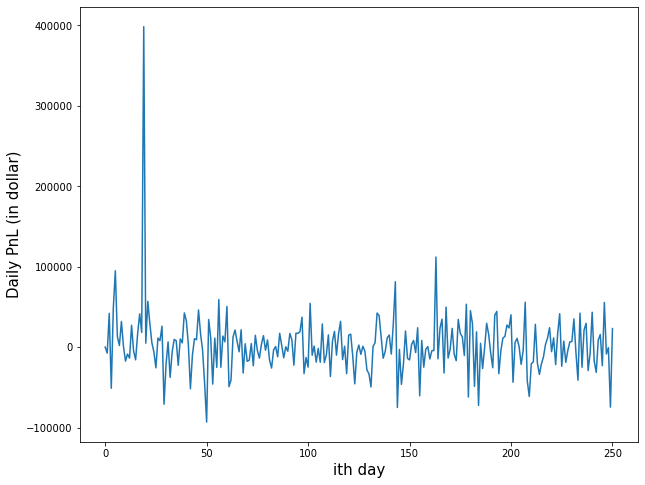

In [18]:
fig,ax = plt.subplots(1,1,figsize=(10,8))
ax.plot(strategy[0]['daily_pnl'].values)
ax.set_xlabel('ith day',fontsize=15)
ax.set_ylabel('Daily PnL (in dollar)',fontsize=15)

Text(0, 0.5, 'Umulative PnL (in dollar)')

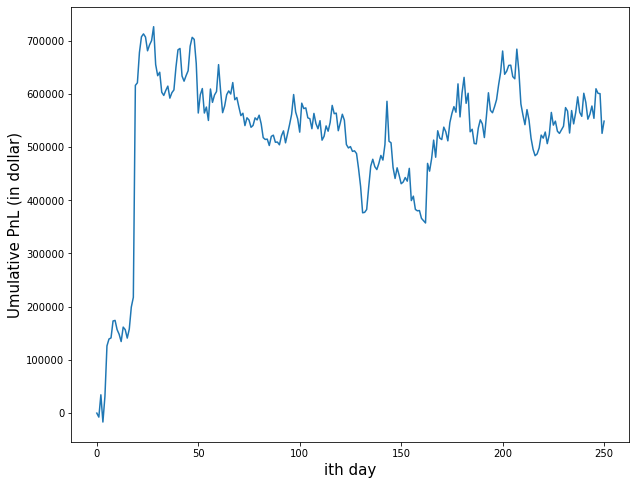

In [19]:
fig,ax = plt.subplots(1,1,figsize=(10,8))
ax.plot(strategy[0]['portfolio_value'].values)
ax.set_xlabel('ith day',fontsize=15)
ax.set_ylabel('Umulative PnL (in dollar)',fontsize=15)

## 4 Reflection, introspection & imporvement

### 4.1  API throttling

As we use batch request to load data from sandbox, instead of putting 500 stocks in a single batch, we seperate them into 5 batchs. That is beacuse of the throttling limits of IEX API. If we try sending a request with a batch of too many tickers, the IEX API will result in an unsuccessful response with a particular response code. In a certain period, users can only send a limitting number of requests

### 4.2 Authentication

To use an API, users should first register and get an ID. This is like they have to create account if they want to log in some Apps. The token is the ID for API users, which will be passed with any requests from the users to IEX cloud. In our project, Authentication is achieved by
```Python
from secrets import IEX_CLOUD_API_TOKEN
```
Without it, any API calls we make will get unsuccesssful responses.

### 4.3 Strategy improvement

The regressors of the cross-sectional regression can be picked not only among technical factors but also fundemental factors. Even among technical factors, we can compute more complex ones. With better factors, our model might have a better performance.

We do not take transaction cost into consideration. It better to predefine the transaction cost percentage in case our pnl is inflated.

## Appendix: trading details

In [20]:
for i in strategy[1]:
    print("\n".join(strategy[1][i]))
    print("\n")
    print("------------------------")

On 2021-05-11,
	
long $497510.7653351935 COTY
short $-1000000.0 FLIR
long $502489.2346648066 OXY
The daily pnl is -7496.096287326705


------------------------
On 2021-05-12,
	
short $-1000000.0 FLIR
long $502901.0081075366 NLOK
long $497098.9918924633 TWTR
The daily pnl is 41921.17489530473


------------------------
On 2021-05-13,
	
long $518260.10388186993 BIIB
long $481739.89611813007 FANG
short $-1000000.0 FLIR
The daily pnl is -51181.2287736123


------------------------
On 2021-05-14,
	
long $526948.737777588 FANG
short $-1000000.0 NVR
long $473051.26222241187 OXY
The daily pnl is 48183.628631007596


------------------------
On 2021-05-17,
	
long $504847.7514101698 MRO
long $495152.2485898301 STX
The daily pnl is 94905.80113746997


------------------------
On 2021-05-18,
	
long $566009.1690985486 DISCK
short $-1000000.0 NVR
long $433990.8309014514 WDC
The daily pnl is 12956.706845206376


------------------------
On 2021-05-19,
	
long $329167.16991564416 BIIB
short $-46056.148